# Seminar 1: Naive word2vec

This task can be formulated very simply. Follow this [paper](https://arxiv.org/pdf/1411.2738.pdf) and implement word2vec like a two-layer neural network with matrices $W$ and $W'$. One matrix projects words to low-dimensional 'hidden' space and the other - back to high-dimensional vocabulary space.

![word2vec](https://i.stack.imgur.com/6eVXZ.jpg)

It is **highly recommended** to read this [paper](https://arxiv.org/pdf/1411.2738.pdf)

Example of visualization in tensorboard:
https://projector.tensorflow.org

Example of 2D visualisation:

![2dword2vec](https://www.tensorflow.org/images/tsne.png)

In [0]:
import numpy as np
import pandas as pd
import collections
import itertools
import nltk
import re
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from nltk.corpus import stopwords
from itertools import zip_longest
from string import ascii_lowercase
import snowballstemmer

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
!wget http://mattmahoney.net/dc/text8.zip
!unzip /content/text8.zip -d text8/

--2020-02-25 22:27:42--  http://mattmahoney.net/dc/text8.zip
Resolving mattmahoney.net (mattmahoney.net)... 67.195.197.75
Connecting to mattmahoney.net (mattmahoney.net)|67.195.197.75|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31344016 (30M) [application/zip]
Saving to: ‘text8.zip’

text8.zip           100%[===================>]  29.89M  2.34MB/s    in 13s     

2020-02-25 22:27:55 (2.31 MB/s) - ‘text8.zip’ saved [31344016/31344016]

Archive:  /content/text8.zip
  inflating: text8/text8             


In [0]:
with open('/content/text8/text8', 'r') as txt_file:
    text_8 = txt_file.read()

In [5]:
print(len(text_8))
text_8[0:500]

100000000


' anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philoso'

In [0]:
class SkipGramBatcher(object):
    def __init__(self, text, window_size = 3, batch_size = 2048, vocab_size=60000):
        self.text = text
        self.preprocessed_text = None

        self.preprocessed = False
        self.word2index = dict()
        self.index2word = dict()

        self.tokens = None
        self.vocab_size = None
        self.window_size = window_size
        self.batch_size = batch_size
        self.last_i = 0
        self.vocab_size = vocab_size
        
    def prepare_text(self, minimum_count=5, stem=False):
        print('Removing punctuation...')
        text_a = re.sub(r'[^\w\s]','',self.text)
        regex_alpha = re.compile('[^a-zA-Z]')
        print('Removing non-alpha...')
        text_b = regex_alpha.sub(' ', text_a)
        print('Lowering...')
        text_c = text_b.lower()
        words_c = text_c.split()
        
        if stem:
            stop = stopwords.words('english')
            stop.extend(['may','also','zero','one','two','three','four','five','six','seven','eight','nine','ten','across','among','beside','however','yet','within']+list(ascii_lowercase))
            stemmer = snowballstemmer.EnglishStemmer()

            stoplist = stemmer.stemWords(stop)
            stoplist = set(stoplist)
            stop = set(sorted(stop + list(stoplist))) 
            print('Removing stop words...')
            words_c = [x for x in words_c if x not in stop]
            print('Stemming stop words...')
            words_c = stemmer.stemWords(words_c)

        self.preprocessed_text = words_c
        str_frequencies = pd.DataFrame(list(collections.Counter(filter(None, self.preprocessed_text)).items()),columns=['word','count'])
        low_frequency_words = set(str_frequencies[str_frequencies['count'] < minimum_count]['word'])

        self.tokens = {x for x in self.preprocessed_text if x not in low_frequency_words}
        # counter = collections.Counter(self.preprocessed_text)
        # self.tokens = {i[0] for i in counter.most_common(self.vocab_size - 2)}

        self.tokens.add('<pad>')
        self.tokens.add('<unk>')

        self.word2index, self.index2word = self.__mapping(self.tokens)
        self.preprocessed = True
        self.vocab_size = len(self.word2index)
        self.numeric_text = ([self.word2index.get(word, self.word2index['<unk>']) for word in self.preprocessed_text])
        print(f'Total number of words in prepared text: {len(self.preprocessed_text)}')
        print(f'Total vocabulary of different words: {self.vocab_size}')
        return self.numeric_text
        
    def __len__(self):
        return len(self.numeric_text)
    
    def __iter__(self):
        if not self.preprocessed:
            raise ValueError('You forgot to call method prepare_text()')
        batch_x = []
        batch_y = []
        tokens = self.numeric_text

        left_number = len(tokens)
        indexes = np.random.permutation(range(left_number))
        residual = left_number % self.batch_size

        for i in indexes:
            token = tokens[i]
            context_left = tokens[max(0, i - self.window_size):i]
            context_right = tokens[i + 1:i + self.window_size + 1]
            context = context_left + context_right
            
            for x, y in zip_longest([token], context, fillvalue=token):
                batch_x.append(x)
                batch_y.append(y)
                
                if len(batch_x) == self.batch_size or (left_number == residual == len(batch_x)):
                    yield np.array(batch_x), np.array(batch_y)
                    batch_x = []
                    batch_y = []
                    left_number -= self.batch_size

    def __mapping(self, tokens):
        word_to_id = dict()
        id_to_word = dict()

        for i, token in enumerate(set(tokens)):
            word_to_id[token] = i
            id_to_word[i] = token

        return word_to_id, id_to_word

In [0]:
skip_gram_batcher = SkipGramBatcher(text_8)

In [8]:
text_preprocessed = skip_gram_batcher.prepare_text(5, False)

Removing punctuation...
Removing non-alpha...
Lowering...
Total number of words in prepared text: 17005207
Total vocabulary of different words: 71292


In [0]:
# for i, batch in enumerate(skip_gram_batcher):
#     if i>=10:
#         break
#     print(batch)

In [9]:
len(skip_gram_batcher)

17005207

In [0]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.W1 = nn.Embedding(vocab_size, embedding_size)
        # self.W2 = nn.Embedding(vocab_size, embedding_size)
        self.W2 = nn.Linear(embedding_size, vocab_size, bias=False)
        self.log_soft = nn.LogSoftmax(dim = 1)

    def forward(self, x):
        x = self.W1(x)
        x = self.W2(x)
        x = self.log_soft(x)
        return x

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [17]:
model = SkipGram(skip_gram_batcher.vocab_size, 300)
model.to(device)

SkipGram(
  (W1): Embedding(71292, 300)
  (W2): Linear(in_features=300, out_features=71292, bias=False)
  (log_soft): LogSoftmax()
)

In [0]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60, gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.1, verbose=True)

In [0]:
epochs = 10
train_losses = []
verbose_at_batch = 1000

In [0]:
def train_model(model, loss_function, optimizer, scheduler, train_losses, verbose_at_batch, epochs):
    for epoch in range(epochs):
        model.train()
        batch_cnt = 0
        x_cnt = 0

        train_loss = 0.
        train_acc = 0.

        start = time.time()
        for central_words, context_words in skip_gram_batcher:
            batch_cnt += 1
            x_cnt += 1 * len(central_words)
            central_words = torch.from_numpy(central_words).to(device)
            context_words = torch.from_numpy(context_words).to(device)
            
            optimizer.zero_grad()
            
            log_probs = model(central_words)
            loss = loss_function(log_probs, context_words)
            preds_class = log_probs.argmax(dim=1)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += (preds_class == context_words).float().mean()

            if batch_cnt % verbose_at_batch == 0:
                end = time.time()
                train_losses.append(train_loss / batch_cnt)
                scheduler.step(metrics = train_loss / batch_cnt)
                print(f"Epoch {epoch + 1} / { epochs } \t Batch {batch_cnt} \t Current loss: {train_loss / batch_cnt:.8f} \t Batch Time: {(end - start):.4f}")

        end = time.time()
        avg_loss = train_loss / batch_cnt
        print(f"Epoch {epoch + 1} / { epochs } \t Current loss: {avg_loss:.8f} \t Epoch Time: {(end - start):.4f}")

    return model

In [21]:
model = train_model(model, criterion, optimizer, scheduler, train_losses, verbose_at_batch, epochs)

Epoch 1 / 10 	 Batch 1000 	 Current loss: 8.61436783 	 Batch Time: 66.5356
Epoch 1 / 10 	 Batch 2000 	 Current loss: 8.13163337 	 Batch Time: 125.9669
Epoch 1 / 10 	 Batch 3000 	 Current loss: 7.90396528 	 Batch Time: 185.4101
Epoch 1 / 10 	 Batch 4000 	 Current loss: 7.77014536 	 Batch Time: 244.8403
Epoch 1 / 10 	 Batch 5000 	 Current loss: 7.67843579 	 Batch Time: 304.2699
Epoch 1 / 10 	 Batch 6000 	 Current loss: 7.61069631 	 Batch Time: 363.7393
Epoch 1 / 10 	 Batch 7000 	 Current loss: 7.55916785 	 Batch Time: 423.2191
Epoch 1 / 10 	 Batch 8000 	 Current loss: 7.51819266 	 Batch Time: 482.6999
Epoch 1 / 10 	 Batch 9000 	 Current loss: 7.48418816 	 Batch Time: 542.1474
Epoch 1 / 10 	 Batch 10000 	 Current loss: 7.45497335 	 Batch Time: 601.6001
Epoch 1 / 10 	 Batch 11000 	 Current loss: 7.42996563 	 Batch Time: 661.0776
Epoch 1 / 10 	 Batch 12000 	 Current loss: 7.40813359 	 Batch Time: 720.5524
Epoch 1 / 10 	 Batch 13000 	 Current loss: 7.38927234 	 Batch Time: 780.0221
Epoch 1 /

KeyboardInterrupt: ignored

Text(0, 0.5, 'Training Loss')

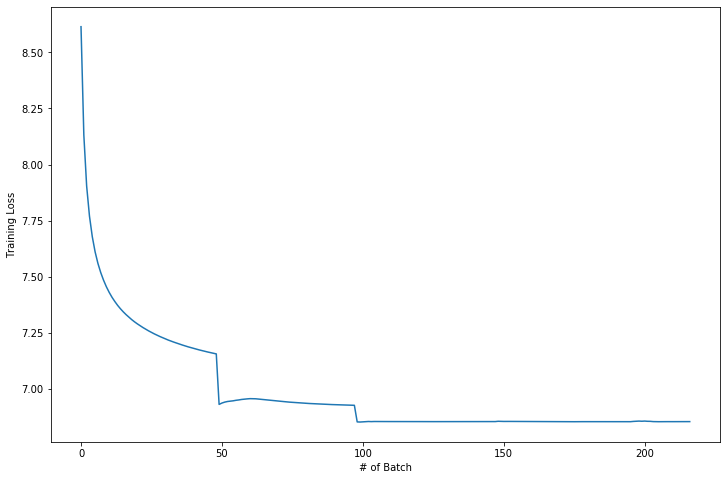

In [22]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 8))
plt.plot(train_losses, label='Batch loss')
plt.xlabel(f'# of Batch')
plt.ylabel('Training Loss')

In [0]:
14*40/60

9.333333333333334

Google Colab offered me the Tesla P100. It took me 78 minutes to train 1 epoch.

In [23]:
!nvidia-smi

Wed Feb 26 02:28:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    39W / 250W |   5367MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
embedding = (model.W1.weight.cpu().data.numpy() + model.W2.weight.cpu().data.numpy()) / 2

with open('embeddings.vec', 'w') as f:
    f.write('%d %d\n' % (len(skip_gram_batcher.index2word), model.W1.embedding_dim))
    for wid, w in skip_gram_batcher.index2word.items():
        e = ' '.join(map(lambda x: str(x), embedding[wid]))
        f.write('%s %s\n' % (w, e))

In [0]:
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE

In [26]:
w2v = KeyedVectors.load_word2vec_format('embeddings.vec')
def plot_with_labels(low_dim, labels):
    plt.figure(figsize=(14, 12))
    for i, label in enumerate(labels):
        x, y = low_dim[i, :]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
def plot_words(indexes):
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    low_dim_embs = tsne.fit_transform(embedding[indexes])
    plot_with_labels(low_dim_embs, [skip_gram_batcher.index2word[i] for i in indexes])

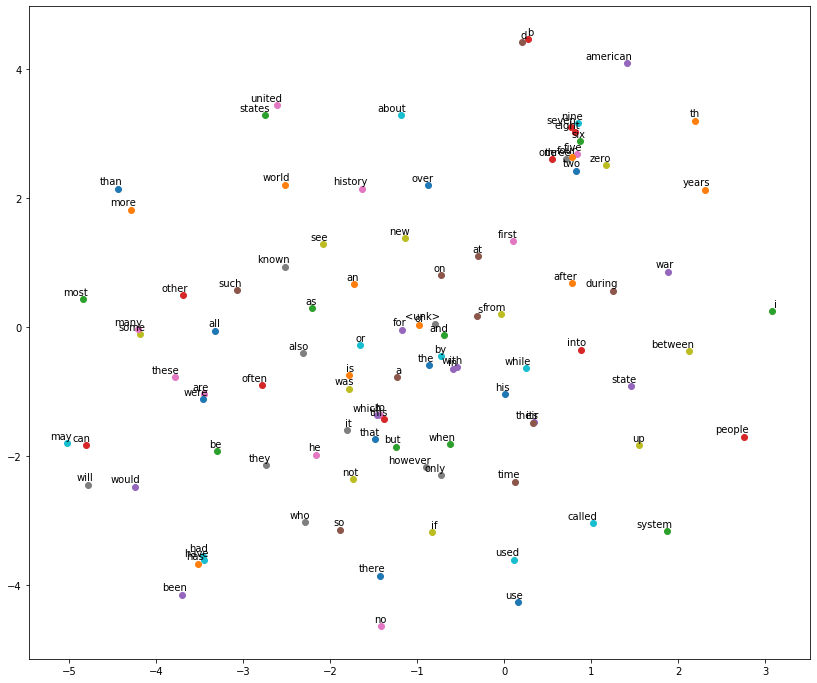

In [28]:
most_common_idx = [i[0] for i in collections.Counter(skip_gram_batcher.numeric_text).most_common(100)]
plot_words(most_common_idx)

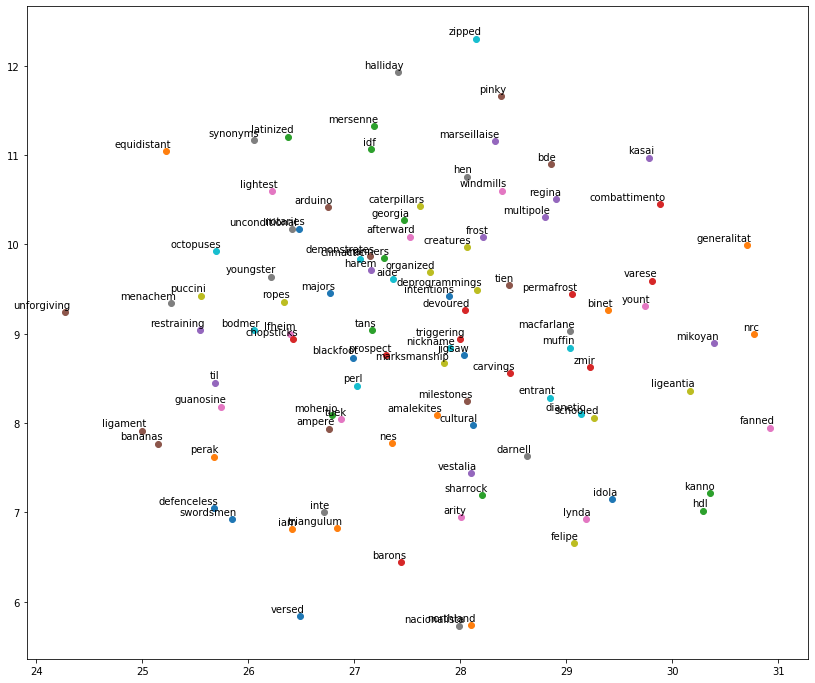

In [30]:
random_ix = np.random.choice(np.arange(skip_gram_batcher.vocab_size), 100, replace=False)
plot_words(random_ix)

### Analogies

In [36]:
w2v.most_similar(positive=['russia', 'america'], negative=['mexico'])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('afghanistan', 0.22786374390125275),
 ('atlas', 0.21883811056613922),
 ('asia', 0.21289925277233124),
 ('marat', 0.20512625575065613),
 ('serbia', 0.20470204949378967),
 ('spanning', 0.20447131991386414),
 ('thrives', 0.2020869106054306),
 ('jews', 0.2018151879310608),
 ('neopagan', 0.2005336582660675),
 ('abroad', 0.19939011335372925)]

In [32]:
w2v.most_similar("english")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('american', 0.3287109136581421),
 ('language', 0.30026334524154663),
 ('archaic', 0.2946878671646118),
 ('irish', 0.2826853096485138),
 ('german', 0.2686241865158081),
 ('british', 0.2630162537097931),
 ('pronunciation', 0.25581973791122437),
 ('spelling', 0.24949049949645996),
 ('french', 0.24539664387702942),
 ('canadian', 0.2450648546218872)]